In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import keras_tuner as kt
from kerastuner.tuners import BayesianOptimization
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import plotnine as p9
from scipy.stats import boxcox
import warnings
import matplotlib.pyplot as plt
import functools
from functools import partial

2024-11-13 12:19:30.068441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/4h/6bn5qz_s6n1f2ht3cjqpzlb40000gp/T/ipykernel_87546/774666631.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


**Data - "Commercial Buildings Energy Consumption Survey (CBECS)"**


- The **Commercial Buildings Energy Consumption Survey (CBECS)** is a national sample survey that collects information on the stock of U.S. commercial buildings, including their energy-related building characteristics and energy usage data (consumption and expenditures). 
<br>
<br>
- Commercial buildings include all buildings in which at least half of the floorspace is used for a purpose that is not residential, industrial, or agricultural. 
<br>
<br>
- By this definition, CBECS includes building types that might not traditionally be considered commercial, such as schools, hospitals, correctional institutions, and buildings used for religious worship, in addition to traditional commercial buildings such as stores, restaurants, warehouses, and office buildings.

<font color = 'green'>
This project will be using the <span style="color: green; font-weight: bold;">2018 CBECS survey data</span> to predict <span style="color: green; font-weight: bold;">Annual Electricity Consumption in kWh</span>. CBECS survey has been conducted since 1979, and over the years the variables and approach has changed. 

2018 is the most recent year of the survey. Out of over 600 variables, roughly 70 were selected based on relevance to the response (domain knowledge) and with the aim to avoid redundancy (e.g., not selecting multiple variables that measure the same thing). Selected features could be summarized into the following categories:
    
**1. Structural building characteristics:** construction materials etc.
<br>
**2. Capacity:** number of seats, beds, roots etc.
<br>
**3. Electrical equipment:** computers, cash registers, servers
<br>
**4. Types of HVAC equipment**
<br>
**5. Lighting**
<br>
**6. Regrigeration**

In [63]:
# Import data
buildings2018 = pd.read_csv('cbecs2018_final_public.csv', index_col = 'INDEX')
buildings2012 = pd.read_csv('2012_public_use_data_aug2016.csv', index_col = 'INDEX')

# Preview data
buildings2018.head()

,PUBID,REGION,CENDIV,PBA,PUBCLIM,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,...,ZMFBTU,ZMFEXP,ZELCNS,ZELEXP,ZNGCNS,ZNGEXP,ZFKCNS,ZFKEXP,ZDHBTU,ZDHEXP
INDEX,,,,,,,,,,,,,,,,,,,,,
6722,1,3,5,2,3,210000,8,1,4,2,...,0,0,0,0,9,9,1,1,0,0
6723,2,4,9,2,4,28000,5,1,6,1,...,0,0,0,0,0,0,9,9,9,9
6724,3,3,5,8,4,2100,2,1,4,2,...,0,0,0,0,9,9,9,9,9,9
6725,4,3,7,5,5,240000,8,2,6,1,...,0,0,0,0,1,1,9,9,9,9
6726,5,1,2,5,3,295000,8,3,6,2,...,0,0,0,0,0,0,9,9,9,9


In [68]:
# Import selected variables
selected = pd.read_csv('selected_variables.csv')

In [69]:
selected.head()

,2018_variable,2012_variable,variable_type,variable_group,label
0,PBA,PBA,C,building characteristic,Principal building activity
1,SQFT,SQFT,N,building characteristic,Square footage
2,WLCNS,WLCNS,C,building characteristic,Wall construction material
3,RFCNS,RFCNS,C,building characteristic,Roof construction material
4,BLDSHP,BLDSHP,C,building characteristic,Building shape


In [70]:
# Obtain names of numeric and categorical variables
numeric = list(selected[selected['variable_type']=='N']['2018_variable'])
categorical = list(selected[selected['variable_type']=='C']['2018_variable'])
variables = numeric + categorical
variables2012 = [var for var in selected['2012_variable'] if pd.notnull(var)]

In [71]:
# Subset the whole dataset to include selected variables, add new 2018 variables to 2012 as blanks
buildings2018_v2 = buildings2018[variables]
buildings2012_v2 = buildings2012[variables2012]
buildings2012_v2 = buildings2012_v2.rename(columns = {"ZHTVVAV": "VAV", "ZHTVOAS": "DOAS", "ZHTVDEM": "DCV"})

# Combine the two datasets into one with a vertical join, preserve the index
cbecs = pd.concat([buildings2012_v2, buildings2018_v2], ignore_index = False)

# Remove rows where the response is blank
cbecs = cbecs[~cbecs['ELCNS'].isna()]
cbecs.shape

(12911, 70)

In [72]:
cbecs.head()

,PBA,SQFT,WLCNS,RFCNS,BLDSHP,GLSSPC,NFLOOR,YRCONC,FLCEILHT,NELVTR,...,MONUSE,OCCUPYP,WKHRS,VAV,DOAS,DCV,LGOFFDEVN,SMOFFDEVN,ATMN,TABLETN
INDEX,,,,,,,,,,,,,,,,,,,,,
1,26,2400,4,2,2.0,1.0,1,5,8,NaN,...,12,NaN,16,9.0,9.0,9.0,NaN,NaN,NaN,NaN
2,23,114000,3,6,6.0,2.0,1,6,12,NaN,...,12,42.0,72,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,15,2550,4,4,2.0,4.0,1,3,12,NaN,...,3,NaN,40,9.0,9.0,9.0,NaN,NaN,NaN,NaN
4,18,500000,6,1,9.0,5.0,994,6,8,9.0,...,12,NaN,168,0.0,0.0,0.0,NaN,NaN,NaN,NaN
5,2,30000,3,6,1.0,2.0,2,5,14,1.0,...,12,100.0,65,0.0,0.0,0.0,NaN,NaN,NaN,NaN


### Work with Numeric Variables: address coding issues and missing values

1. <span style="color:blue">**Building Characteristics:**</span>
    - **FLCEILHT**:	Floor to ceiling height
	- **NELVTR**:	Number of elevators
	- **NESLTR**:	Number of escalators
	- **NFLOOR**:	Number of floors
	- **SQFT**:	Square footage
<br>
<br>
2.  <span style="color:blue">**Capacity:**</span>	
    - **EDSEAT**:	Number of classroom seats
	- **FDSEAT**:	Food service seating capacity
	- **HCBED**:	Licensed inpatient beds
	- **LODGRM**:	Number of guest rooms
	- **NRSBED**:	Licensed nursing beds
	- **NWKER**:	Number of employees
	- **PBSEAT**:	Assembly seating capacity
	- **RWSEAT**:	Religious worship seating capacity
    - **NOCC**: Number of businesses
<br>
<br>
3. <span style="color:blue">**Climate:**</span>		
    - **CDD65**:	Cooling degree days (base 65)
<br>
<br>
4. <span style="color:blue">**Equipment:**</span>		
    - **LAPTPN**:	Number of laptops
	- **LGOFFDEVN**:	Number of large office devices
	- **PCTERMN**:	Number of desktop computers
    - **SERVERN**: Number of servers or racks
    - **TABLETN**: Number of tabletsm
	- **RGSTRN**:	Number of point-of-sales or cash registers
	- **SMOFFDEVN**:	Number of small office devices
	- **TVVIDEON**:	Number of TV or video displays
    - **XRAYN**: Number of X-ray machines
    - **ATMN**: Number of ATMs
<br>
<br>
7. <span style="color:blue">**Refrigeration:**</span>		
    - **RFGCLN**:	Number of closed refrigerated cases
	- **RFGCOMPN**:	Number of compact refrigerators
	- **RFGICN**:	Number of commercial ice makers
	- **RFGOPN**:	Number of open refrigerated cases
	- **RFGRSN**:	Number of residential refrigerators
	- **RFGVNN**:	Number of vending machines
	- **RFGWIN**:	Number of walk-in units
<br>
<br>
8. <span style="color:blue">**Response Variable:**</span>	
    - **ELCNS**:	Annual electricity consumption (kWh)
<br>
<br>
9. <span style="color:blue">**Usage:**</span>	
    - **MONUSE**:	Months in use
	- **OCCUPYP**:	Percent occupancy
	- **WKHRS**:	Total hours open per week
    - **COOLP**:	Percent SQFT cooled

In [74]:
# Examine numeric variables, look for missing values and inappropriate values
cbecs[numeric].iloc[:, 0:10].describe()

,SQFT,NFLOOR,FLCEILHT,NELVTR,NESLTR,RWSEAT,PBSEAT,EDSEAT,FDSEAT,HCBED
count,1.291100e+04,12911.000000,12911.000000,5079.000000,400.000000,623.000000,895.000000,1691.000000,579.000000,685.000000
mean,1.486161e+05,59.220665,15.277593,15.287458,118.297500,3905.504013,23449.526257,806.949734,110.214162,4874.686131
std,2.746420e+05,230.463868,45.354108,100.788389,316.442425,18402.505538,147741.591239,864.656399,109.414338,4926.133854
min,1.001000e+03,1.000000,6.000000,1.000000,1.000000,20.000000,0.000000,10.000000,0.000000,15.000000
25%,7.000000e+03,1.000000,9.000000,1.000000,2.000000,150.000000,80.000000,250.000000,45.000000,150.000000
50%,4.300000e+04,2.000000,10.000000,3.000000,4.000000,250.000000,225.000000,600.000000,80.000000,250.000000
75%,1.740000e+05,3.000000,15.000000,6.000000,8.000000,500.000000,800.000000,1000.000000,150.000000,9995.000000
max,2.100000e+06,995.000000,995.000000,995.000000,995.000000,99995.000000,999995.000000,10000.000000,1000.000000,9995.000000


In [75]:
# Correct coding issues, populate missing values as appropriate

# Number of above-ground floors, 994 is 10 to 14, 995 is > 14
cbecs.loc[cbecs['NFLOOR']==994, 'NFLOOR'] = 12
cbecs.loc[cbecs['NFLOOR']==995, 'NFLOOR'] = 15

# Floor to ceiling height, 995 = more than 50
cbecs.loc[cbecs['FLCEILHT']==995, 'FLCEILHT'] = 51

# Number of elevators, 995 = more than 30, missing - n/a
cbecs.loc[cbecs['NELVTR']==995, 'NELVTR'] = 31
cbecs['NELVTR'] = cbecs.NELVTR.fillna(0)

# Number of escalators, 995 = more than 10, missing - n/a
cbecs.loc[cbecs['NESLTR']==995, 'NESLTR'] = 11
cbecs['NESLTR'] = cbecs.NESLTR.fillna(0)

# Create new variable number of elevators + number of escalators
cbecs['NELEVESC'] = cbecs['NELVTR'] + cbecs['NESLTR']

# Delete escalator and elevator variables, as we no longer need them
cbecs = cbecs.drop(['NELVTR', 'NESLTR'], axis=1)

We will consolidate the following variables into one variable called "Capacity":

1. RWSEAT - Religious seating capacity
2. PBSEAT - Assembly seating capacity
3. EDSEAT - Number of classroom seats
4. FDSEAT - Food Service Seating capacity
5. HCBED - Licensed inpatient beds
6. NRSBED - Licensed nursing beds
7. LODGRM - Number of guest rooms
8. NWKER - Number of employees


For "Capacity" we will use values from variables 1 through 7. If those are not applicable, then we will use number of employees. Capacity is important for predicting electricity consumption as it gives us an idea about usage and occupant density. These affect lighting and HVAC utilization.

But before we do that, we need to take care of non-standard and missing values.

In [76]:
# Take care of all variables that will be part of "Capacity"

# 1. Religious seating, 99995  - more than 2000, missing - n/a
cbecs.loc[cbecs['RWSEAT']==99995, 'RWSEAT'] = 2050
cbecs['RWSEAT'] = cbecs.RWSEAT.fillna(0)

# 2. Assembly seating, 999995 - more than 15K, missing - n/a
cbecs.loc[cbecs['PBSEAT']==999995, 'PBSEAT'] = 15500
cbecs['PBSEAT'] = cbecs.PBSEAT.fillna(0)

# 3. Classroom seats, missing - n/a
cbecs['EDSEAT'] = cbecs.EDSEAT.fillna(0)

# 4. Food Service seating, missing - n/a
cbecs['FDSEAT'] = cbecs.FDSEAT.fillna(0)

# 5. Licensed Inpatient Beds, 9995 - more than 250, missing - n/a
cbecs.loc[cbecs['HCBED']==9995, 'HCBED'] = 260
cbecs['HCBED'] = cbecs.HCBED.fillna(0)

# 6. Licensed nursing beds, 9995 - more than 250, missing - n/a
cbecs.loc[cbecs['NRSBED']==9995, 'NRSBED'] = 260
cbecs['NRSBED'] = cbecs.NRSBED.fillna(0)

# 7. Number of guest rooms, 99995 - more than 1000, missing - n/a
cbecs.loc[cbecs['LODGRM']==99995, 'LODGRM'] = 1100
cbecs['LODGRM'] = cbecs.LODGRM.fillna(0)

# Create variable capacity
cbecs['CAPACITY'] = cbecs.RWSEAT + cbecs.PBSEAT + cbecs.EDSEAT + cbecs.FDSEAT + cbecs.HCBED + \
cbecs.NRSBED + cbecs.LODGRM


Note: I am making a judgment call to sum "seats" and "guest rooms" because on average any hotel room would house only one person.

In [77]:
# If 'Capacity' is blank, populate with the number of employees
cbecs.loc[cbecs['CAPACITY']==0, 'CAPACITY'] = cbecs['NWKER']

# Delete the columns that we no longer need
cbecs = cbecs.drop(['RWSEAT', 'PBSEAT', 'EDSEAT','FDSEAT', 'HCBED', 'NRSBED', 'LODGRM','NWKER'], axis = 1)

# Update numeric variables
numeric2 = list(set(numeric) - set(['NELVTR', 'NESLTR','RWSEAT', 'PBSEAT', \
                                   'EDSEAT', 'HCBED', 'NRSBED', 'LODGRM', 'FDSEAT','NWKER']))

In [78]:
cbecs.shape

(12911, 62)

We will consolidate the following variables:
    
New variable called "FRIDGE" will be the total of all refrigeration units and vending machines
1. RFGRSN - Number of residential refrigerators
2. RFGCOMPN - Number of compact refrigerators
3. RFGWIN - Number of walk-in units
4. RFGOPN - Number of open refrigerated cases
5. RFGCLN - Number of closed refrigerated cases
6. RFGVNN - Number of vending machines
7. RFGICN - Number of commercial ice makers

New variable called 'EQUIP' will be the total of all equipment (+ cash registers)
1. PCTERMN - number of desktop computers
2. LAPTPN - number of laptops
3. LGOFFDEVN - number of large office devices
4. SMOFFDEVN - number of small office devices
5. TVVIDEON - number of tv or video displays
6. RGSTRN - number of POS or cash registers
7. XRAYN - number of X-ray machines
8. ATMN - number of ATMs
9. SERVERN - number of servers or racks
10. TABLETN - number of tablets

In [79]:
# 1. Number of residential refrigerators, 99995 = more than 1000, randomly populate with 1050, missing - n/a
cbecs.loc[cbecs['RFGRSN']==99995, 'RFGRSN'] = 1050
cbecs['RFGRSN'] = cbecs.RFGRSN.fillna(0)

# 2. Number of compact refrigerators, 99995 = more than 1000, randomly populate with 1050
cbecs.loc[cbecs['RFGCOMPN']==99995, 'RFGCOMPN'] = 1050

# 3. Number of walk-in refrigerators, missing - not applicable: populate with zeros
cbecs.RFGWIN = cbecs.RFGWIN.fillna(0)

# 4. Numer of open refrigerated cases, missing - not applicable: populate with zeros
cbecs.RFGOPN = cbecs.RFGOPN.fillna(0)

# 5. Number of closed refrigerated cases, missing - not applicable: populate with zeros
cbecs.RFGCLN = cbecs.RFGCLN.fillna(0)

# 6. Number of vending machines, missing - not applicable: populate with zeros
cbecs.RFGVNN = cbecs.RFGVNN.fillna(0)

# 7. Number of commercial ice makers, missing - not applicable: populate with zeros
cbecs.RFGICN = cbecs.RFGICN.fillna(0)


In [80]:
# 1. Number of desktop computers, missing - not applicable: populate with zeros
cbecs.PCTERMN = cbecs.PCTERMN.fillna(0)

# 2. Number of laptop computers, missing - not applicable: populate with zeros
cbecs.LAPTPN = cbecs.LAPTPN.fillna(0)

# 3. Numer of large office devices, 9995 - more than 500, missing - n/a
cbecs.loc[cbecs['LGOFFDEVN']==9995, 'LGOFFDEVN']= 510
cbecs.LGOFFDEVN = cbecs.LGOFFDEVN.fillna(0)

# 4. Number of small office devices, 9995 - more than 500, missing - n/a
cbecs.loc[cbecs['SMOFFDEVN']==9995, 'SMOFFDEVN']= 510
cbecs.SMOFFDEVN = cbecs.SMOFFDEVN.fillna(0)

# 5. Number of TV/video displays, 995 - more than 200, missing - n/a
cbecs.loc[cbecs['TVVIDEON']==995, 'TVVIDEON']= 210
cbecs.TVVIDEON = cbecs.TVVIDEON.fillna(0)

# 6. Number of cash registers/POS systems, missing - n/a
cbecs.RGSTRN = cbecs.RGSTRN.fillna(0)

# 7. Number of Xray machines, 995 - more than 20, missing - n/a
cbecs.loc[cbecs['XRAYN']==995, 'XRAYN'] = 25
cbecs.XRAYN = cbecs.XRAYN.fillna(0)

# 8. Number of ATMs, 3 = 3 or more, missing - n/a
cbecs.loc[cbecs['ATMN'] == 3, 'ATMN'] = 4
cbecs.ATMN = cbecs.ATMN.fillna(0)

# 9. Number of servers or racks, 9995 = more than 500, missing - n/a
cbecs.loc[cbecs['SERVERN'] == 9995, 'SERVERN'] = 550
cbecs.SERVERN = cbecs.SERVERN.fillna(0)

# 10. Number of tablets, missing - n/a
cbecs.TABLETN = cbecs.TABLETN.fillna(0)

In [81]:
# Create a unified variable for refrigeration
cbecs['FRIDGE'] = cbecs['RFGRSN'] + cbecs['RFGOPN'] +  cbecs['RFGCOMPN'] + cbecs['RFGWIN'] + cbecs['RFGCLN'] + \
cbecs['RFGVNN'] + cbecs['RFGICN']

# Create a unitified veriable for equipment
cbecs['EQUIP'] = cbecs.PCTERMN + cbecs.LAPTPN + cbecs.LGOFFDEVN + cbecs.SMOFFDEVN + cbecs.TVVIDEON + \
cbecs.RGSTRN + cbecs.XRAYN + cbecs.ATMN + cbecs.SERVERN + cbecs.TABLETN

# Delete the columns that we no longer need
cbecs = cbecs.drop(['RFGRSN', 'RFGOPN', 'RFGCOMPN', 'RFGWIN', 'RFGCLN', 'RFGVNN', 'RFGICN',\
                   'PCTERMN', 'LAPTPN' , 'LGOFFDEVN', 'SMOFFDEVN', 'TVVIDEON', 'RGSTRN'], axis = 1)

# Update numeric variables by subtracting dropped variables
numeric3 = list(set(numeric2) - set(['RFGRSN', 'RFGOPN', 'RFGCOMPN', 'RFGWIN', 'RFGCLN', 'RFGVNN', 'RFGICN',\
                   'PCTERMN', 'LAPTPN' , 'LGOFFDEVN', 'SMOFFDEVN', 'TVVIDEON', 'RGSTRN', \
                                    'XRAYN', 'ATMN', 'SERVERN', 'TABLETN']))

# Update numeric variables by adding newly created variables
for item in ['FRIDGE', 'CAPACITY', 'EQUIP', 'NELEVESC']:
    numeric3.append(item)

In [82]:
# Look at all remaining numeric variables
cbecs[numeric3].iloc[:, 0:10].describe()

,NFLOOR,NOCC,COOLP,CDD65,FLCEILHT,ELCNS,WKHRS,SQFT,OCCUPYP,MONUSE
count,12911.000000,12911.000000,12016.000000,12911.000000,12911.000000,1.291100e+04,12911.000000,1.291100e+04,3672.000000,12911.000000
mean,3.066532,7.171791,80.497170,1666.148633,13.303462,2.713514e+06,81.272481,1.486161e+05,89.075708,11.543258
std,3.325160,56.942636,29.618636,1007.149366,6.951381,8.091059e+06,51.563060,2.746420e+05,16.319249,1.742342
min,1.000000,0.000000,1.000000,10.000000,6.000000,0.000000e+00,0.000000,1.001000e+03,13.000000,0.000000
25%,1.000000,1.000000,75.000000,943.000000,9.000000,6.593500e+04,45.000000,7.000000e+03,82.000000,12.000000
50%,2.000000,1.000000,100.000000,1445.000000,10.000000,4.135590e+05,60.000000,4.300000e+04,98.000000,12.000000
75%,3.000000,2.000000,100.000000,2083.500000,15.000000,2.162846e+06,112.000000,1.740000e+05,100.000000,12.000000
max,15.000000,996.000000,100.000000,5871.000000,51.000000,3.987680e+08,168.000000,2.100000e+06,100.000000,12.000000


In [83]:
cbecs[numeric3].iloc[:, 10:20].describe()

,FRIDGE,CAPACITY,EQUIP,NELEVESC
count,4925.000000,12911.000000,12911.000000,12911.000000
mean,57.403046,364.953993,331.764155,2.215785
std,122.878804,1056.750256,782.023996,5.289825
min,1.000000,0.000000,0.000000,0.000000
25%,6.000000,12.000000,8.000000,0.000000
50%,19.000000,90.000000,42.000000,0.000000
75%,58.000000,300.000000,266.000000,2.000000
max,2154.000000,15500.000000,8585.000000,59.000000


- Variable **OCCUPYP** (percent occupancy), missing values are not applicable. Does that mean that it's an industrial building that would not have any occupants? Too many missing, need to remove this variable.
- Variable **FRIDGE** (newly created to capture all refrigeration), missing needs to be populated with 0.
- Variable **NOCC** (number of businesses) - correct coding issues
- Variable **COOLP** (percent sqft that is cooled) - missing values mean "not applicable", so no cooling in this building; will populate with zeros.

In [89]:
# Refrigeration, missing - n/a
cbecs['FRIDGE'] = cbecs.FRIDGE.fillna(0)

# Drop variable
cbecs = cbecs.drop(['OCCUPYP'], axis = 1)
numeric3.remove('OCCUPYP')

# Number of business: 996 - blank to protect confidentiality, populate with median
cbecs.loc[cbecs['NOCC']==996, 'NOCC']= 1

# Percent sqft that is cooled: missing - populate with zero
cbecs['COOLP'] = cbecs.COOLP.fillna(0)

In [90]:
cbecs.shape

(12911, 50)

### Work with categorical variables: address missing values, check counts by category

There a lot of categorical variables. Some are key to the prediction, like the type of HVAC equipment. Others may be able to be removed if they are either too sparse or too homogenous

1. <span style="color:blue">**Building Characteristics:**</span>	
    - **ATTIC**: Attic presence
	- **BLDSHP**: Building shape
	- **GLSSPC**: Percent exterior glass
	- **PBA**: Principal building activity
	- **RFCNS**:	Roof construction material
	- **RFCOOL**:	Cool roof
	- **RFTILT**:	Roof tilt
	- **WLCNS**:	Wall construction material
	- **YRCONC**:	Year of construction category
	- **WINTYP**:	Window glass type
    - **CENDIV**: Census Division (location)
<br>
<br>
2. <span style="color:blue">**Cooking, Water Heating, Manufacturing:**</span>
    - **ELCOOK**:	Electricity used for cooking
    - **ELWATR**:	Electricity used for water heating
    - **ELMANU**:	Electricity used for manufacturing
<br>
<br>
3. <span style="color:blue">**HVAC	and Smart Controls:**</span>	
    - **MAINCL**:	Main air-conditioning equipment
    - **MAINHT**:	Main heating equipment
    - **MAINT**:	Regular HVAC maintenance
    - **DOAS**:	Dedicated outside air system (DOAS)
	- **VAV**:	Variable air volume (VAV) system
    - **DCV**:	Demand controlled ventilation (DCV)
    - **EMCS**:	Building automation system (BAS)
    - **PLANT**: Presence of a centralized plant that produces hot water or steam
    - **SLFCON**: Presence of space heaters
<br>
<br>
4. <span style="color:blue">**Lighting:**</span>		
    - **BULB**:	Incandescent light bulbs
	- **CFLR**:	Compact fluorescent (CFL) bulbs
	- **FLUOR**: Fluorescent bulbs	
	- **HALO**:	Halogen bulbs
	- **HID**:	High intensity discharge (HID) lighting
	- **LED**:	LED lighting
	- **PKLT**:	Lighted parking area
<br>
<br>
5. <span style="color:blue">**Renovations:**</span>	
    - **RENHVC**:	HVAC upgrade since 2000?
	- **RENINS**:	Insulation upgrade since 2000?
	- **RENELC**:	Electric Upgrade sinsce 2000?

In [91]:
cbecs2 = cbecs.copy()

In [92]:
# Check missing values first
for var in categorical:
    print(f"Variable {var} Missing: ", cbecs2[var].isna().sum())

Variable PBA Missing:  0
Variable WLCNS Missing:  0
Variable RFCNS Missing:  0
Variable BLDSHP Missing:  593
Variable GLSSPC Missing:  593
Variable YRCONC Missing:  0
Variable RFTILT Missing:  0
Variable ATTIC Missing:  0
Variable RFCOOL Missing:  0
Variable WINTYP Missing:  0
Variable CENDIV Missing:  0
Variable PLANT Missing:  7816
Variable ELCOOK Missing:  0
Variable ELMANU Missing:  0
Variable ELWATR Missing:  0
Variable MAINCL Missing:  895
Variable MAINHT Missing:  721
Variable MAINT Missing:  616
Variable EMCS Missing:  355
Variable SLFCON Missing:  721
Variable FLUOR Missing:  152
Variable CFLR Missing:  152
Variable BULB Missing:  152
Variable HALO Missing:  152
Variable HID Missing:  152
Variable LED Missing:  152
Variable PKLT Missing:  0
Variable RENHVC Missing:  3134
Variable RENINS Missing:  3134
Variable RENELC Missing:  3134
Variable VAV Missing:  318
Variable DOAS Missing:  318
Variable DCV Missing:  318


- **BLDSHP**: missing - populate with most popular value
- **GLSSPC**: missing - populate with most popuar value
- **PLANT**: not necessary for electricity consumption prediction, plus if there is a central plant providing energy, it will be captured in the MAINHT variable
- **MAINCL**: missing means not applicable, so no cooling equipment. Create a separate category for missing
- **MAINHT**: missing - unclear why, create separate category
- **MAINT**: missing - regular HVAC maintenance is n/a, populate with '2' - no
- **EMCS**: missing - building automation systems (bas) is n/a, populate with '2' - no
- **SLFCON**: missing - n/a (no space heaters), populate with '2' - no
- All lighting variables: missing - n/a, populate with '2' - no
- All renovation variables: missing - n/a, populate with '2' - no
- All ventilication variables: missing - n/a, populatw with '2' - no

In [107]:
print("Building Shapes", cbecs2['BLDSHP'].value_counts())
print("")
print("Exterior Glass Coverage", cbecs2['GLSSPC'].value_counts())

Building Shapes BLDSHP
2.0     7775
1.0     1046
11.0     804
9.0      768
3.0      695
4.0      497
6.0      357
8.0      310
5.0      276
10.0     212
7.0      171
Name: count, dtype: int64

Exterior Glass Coverage GLSSPC
3.0    4517
2.0    3417
1.0    2536
4.0    1578
5.0     613
6.0     250
Name: count, dtype: int64


In [103]:
# Remove PLANT
cbecs2 = cbecs.drop(['PLANT'], axis = 1)
categorical.remove('PLANT')

# Populate missing
cbecs2['BLDSHP'] = cbecs2.BLDSHP.fillna(2)
cbecs2['GLSSPC'] = cbecs2.GLSSPC.fillna(3)
cbecs2['MAINCL'] = cbecs2.MAINCL.fillna(99)
cbecs2['MAINHT'] = cbecs2.MAINHT.fillna(99)
cbecs2['MAINT'] = cbecs2.MAINT.fillna(2)
cbecs2['EMCS'] = cbecs2.EMCS.fillna(2)
cbecs2['FLUOR'] = cbecs2.FLUOR.fillna(2)
cbecs2['CFLR'] = cbecs2.CFLR.fillna(2)
cbecs2['BULB'] = cbecs2.BULB.fillna(2)
cbecs2['HALO'] = cbecs2.HALO.fillna(2)
cbecs2['HID'] = cbecs2.HID.fillna(2)
cbecs2['LED'] = cbecs2.LED.fillna(2)
cbecs2['RENHVC'] = cbecs2.RENHVC.fillna(2)
cbecs2['RENINS'] = cbecs2.RENINS.fillna(2)
cbecs2['RENELC'] = cbecs2.RENELC.fillna(2)
cbecs2['VAV'] = cbecs2.VAV.fillna(2)
cbecs2['DOAS'] = cbecs2.DOAS.fillna(2)
cbecs2['DCV'] = cbecs2.DCV.fillna(2)
cbecs2['SLFCON'] = cbecs2.SLFCON.fillna(2)

In [104]:
# Look at category counts for building characteristic variables:
cbecs2['PBA'].value_counts() # lots of categories, need to use frequency encoding, 2 - Office is most common

PBA
2     2685
14    1691
5     1409
13     895
26     766
18     713
25     705
16     685
12     623
15     579
23     504
8      414
6      220
1      218
17     208
7      206
91     167
4      110
24      69
11      44
Name: count, dtype: int64

In [106]:
# Look at category counts for building characteristic variables:
print(cbecs2['WLCNS'].value_counts()) # lots of categories, 1 - Brick, Stone, Stucco most common
print("")
print(cbecs2['RFCNS'].value_counts()) # lots of categories, 6 - Plastic, Rubber, Synthetic sheeting most common
print("")
print(cbecs2['WINTYP'].value_counts()) # category 4 is 'no windows', maybe will encode this one with frequency

WLCNS
1    6328
3    2644
5    1190
2    1129
4    1047
6     312
8     167
7      52
9      42
Name: count, dtype: int64

RFCNS
6    4017
1    2919
5    2275
4    2233
2     673
7     275
8     260
3     220
9      39
Name: count, dtype: int64

WINTYP
2    6362
1    3213
3    2908
4     428
Name: count, dtype: int64


In [109]:
# Look at category counts for building characteristic variables:
for var in ['YRCONC', 'RFTILT', 'ATTIC', 'RFCOOL', 'WINTYP', 'CENDIV']:
    print(cbecs2[var].value_counts()) # most categories are not too sparse

YRCONC
6     2115
7     1958
8     1856
5     1756
4     1498
2     1122
3     1062
9      848
10     353
1      343
Name: count, dtype: int64
RFTILT
1    7393
2    3327
3    2191
Name: count, dtype: int64
ATTIC
2    9864
1    3047
Name: count, dtype: int64
RFCOOL
2    8360
1    4551
Name: count, dtype: int64
WINTYP
2    6362
1    3213
3    2908
4     428
Name: count, dtype: int64
CENDIV
5    2599
9    1913
3    1885
2    1619
7    1569
4    1011
8     974
6     748
1     593
Name: count, dtype: int64


In [110]:
# Look at variables for cooking, water heating and manufacturing with electricity:
for var in ['ELCOOK', 'ELWATR', 'ELMANU']:
    print(cbecs2[var].value_counts()) 
    
    # manufacturing with electricity is in the super minority (5%), but will keep this variable for now

ELCOOK
2.0    8740
1.0    4171
Name: count, dtype: int64
ELWATR
2.0    6746
1.0    6165
Name: count, dtype: int64
ELMANU
2.0    12274
1.0      637
Name: count, dtype: int64


In [113]:
# Look at HVAC variables:
for var in ['MAINCL', 'MAINHT', 'MAINT', 'EMCS', 'SLFCON']:
    print(cbecs2[var].value_counts()) # some heating and cooling equipment is pretty rare, will consolidate

MAINCL
2.0     5233
3.0     2362
1.0     1777
5.0      989
99.0     895
4.0      640
6.0      523
16.0     373
7.0       80
8.0       22
14.0      15
12.0       1
10.0       1
Name: count, dtype: int64
MAINHT
2.0     3810
3.0     1392
11.0    1365
10.0    1228
99.0     721
4.0      714
1.0      656
5.0      642
6.0      572
9.0      433
27.0     406
7.0      262
13.0     145
17.0     107
28.0     101
42.0      80
20.0      71
12.0      41
16.0      33
21.0      31
24.0      26
22.0      22
18.0      13
30.0      10
40.0       6
14.0       6
37.0       3
8.0        3
31.0       2
33.0       2
39.0       2
36.0       1
29.0       1
15.0       1
32.0       1
23.0       1
41.0       1
Name: count, dtype: int64
MAINT
1.0    10449
2.0     2462
Name: count, dtype: int64
EMCS
2.0    7314
1.0    5597
Name: count, dtype: int64
SLFCON
2.0    10054
1.0     2857
Name: count, dtype: int64


In [27]:
# Consolidate categories for MAINCL: meain cooling equipment
cbecs2.loc[cbecs2['MAINCL'].isin([6,8,14,12,10,7]), 'MAINCL'] = 999
cbecs2.loc[cbecs2['MAINHT'].isin([20, 12, 16, 21, 24, 22, 18, 30, 14, 40, 8, 37, 39, 33, 31, 29, 15, 36, 32, 23, 41]), 'MAINHT'] = 999

In [28]:
# Look at the variables which represent types of lighting
for variable in ['FLUOR', 'CFLR', 'BULB', 'HALO', 'HID', 'LED', 'PKLT']:
    print(cbecs2[variable].value_counts())

FLUOR
1.0    4881
2.0    1476
Name: count, dtype: int64
CFLR
2.0    3840
1.0    2517
Name: count, dtype: int64
BULB
2.0    4891
1.0    1466
Name: count, dtype: int64
HALO
2.0    5289
1.0    1068
Name: count, dtype: int64
HID
2.0    5529
1.0     828
Name: count, dtype: int64
LED
1.0    4287
2.0    2070
Name: count, dtype: int64
PKLT
1.0    4242
2.0    2115
Name: count, dtype: int64


- Fluorescent lighting: most popular
- Compact fluorescent bulbs: decent use
- Incandescent light bubls: decent use
- Halogen bulbs: decent use
- HID lighting: less popular
- LED lighting: less popular
- Is the partking lot lit: mostly yes
    
Every variable here has a good mix of 'yes' and 'no'.

In [29]:
# Look at the Renovation variables
for var in ['RENHVC', 'RENINS', 'RENELC']:
    print(cbecs2[var].value_counts()) # decent counts in each category

RENHVC
2.0    4252
1.0    2105
Name: count, dtype: int64
RENINS
2.0    5826
1.0     531
Name: count, dtype: int64
RENELC
2.0    5187
1.0    1170
Name: count, dtype: int64


In [30]:
# Look at Ventilation variables
for var in ['VAV', 'DOAS', 'DCV']:
    print(cbecs2[var].value_counts()) # decent counts in each category, except for MRI - pretty sparse

VAV
2.0    4020
1.0    2337
Name: count, dtype: int64
DOAS
2.0    5676
1.0     681
Name: count, dtype: int64
DCV
2.0    5617
1.0     740
Name: count, dtype: int64


# Transform Variables as Needed and Understand Relationships

In [31]:
# Create a copy of the df
cbecs3 = cbecs2.copy()

### Look at distributions of numeric variables and relationships with response

In [32]:
response = cbecs3['ELCNS']

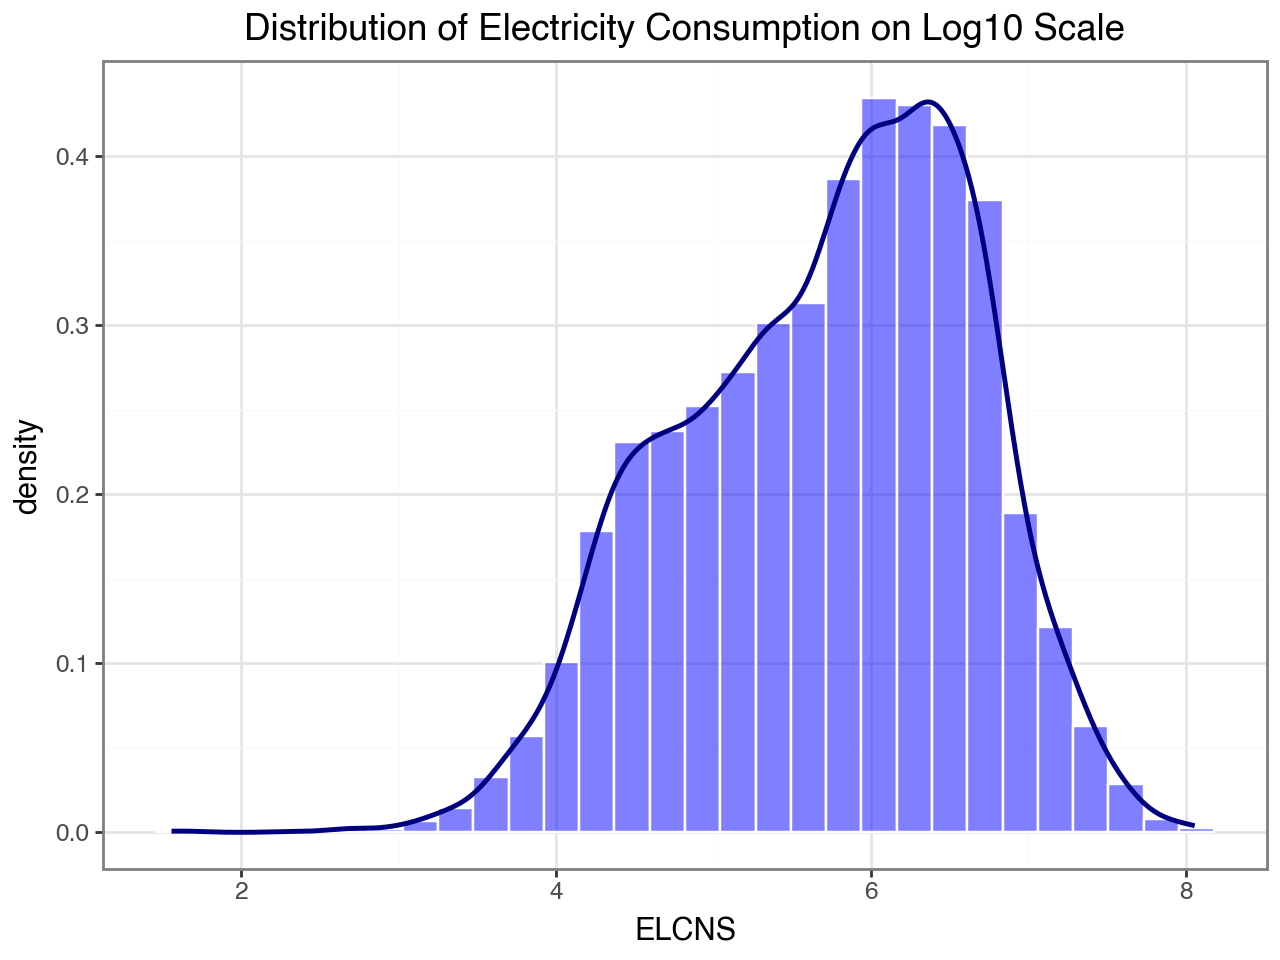

In [34]:
# Plot distribution of response on a log scale, because there are lots of outliers
p9.ggplot(cbecs3, p9.aes(x=np.log10(response))) + p9.geom_histogram(p9.aes(y='..density..'), bins=30, fill="blue", \
                                                         alpha=0.5, color = 'white') + \
p9.stat_density(geom="line", color="navy", size=1) + p9.theme_bw() + \
p9.ggtitle('Distribution of Electricity Consumption on Log10 Scale')

In [35]:
numeric3.remove('ELCNS')

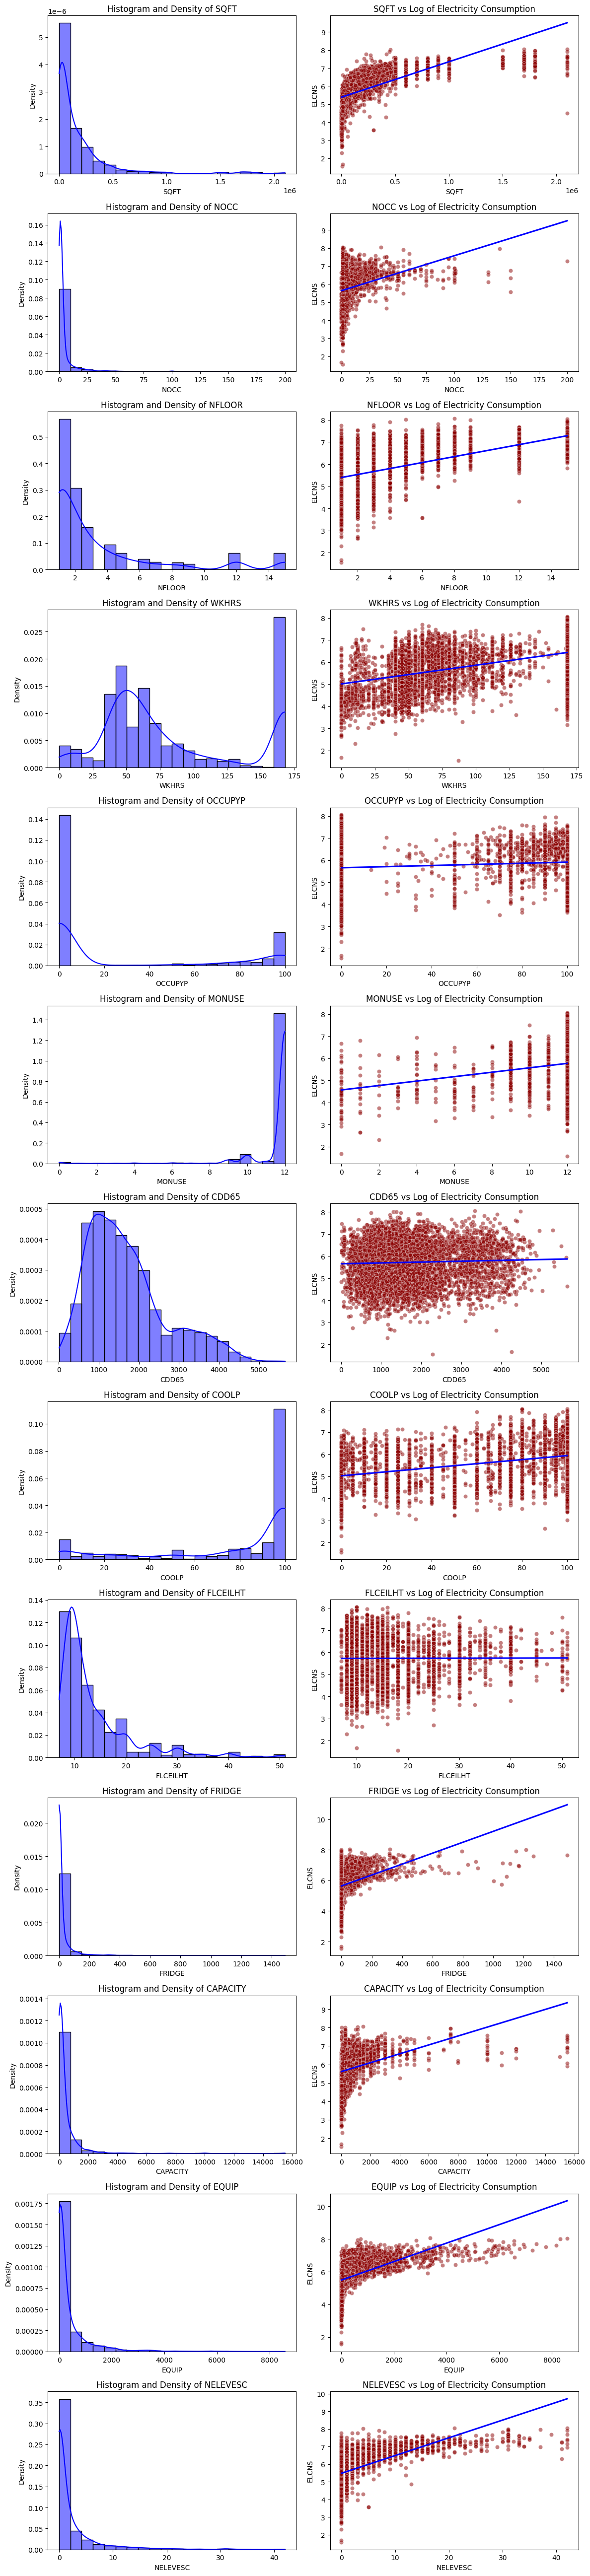

In [36]:
n = len(numeric3)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 4*n))

for i, var in enumerate(numeric3):
    
    # First plot: Histogram with KDE (smooth density plot)
    sns.histplot(cbecs3[var], kde=True, ax=axes[i, 0], color='blue', edgecolor='black', \
                 stat = 'density', bins = 20)
    axes[i, 0].set_title(f'Histogram and Density of {var}')
    
    # Second plot: Scatter plot with response and a smooth fit line
    sns.scatterplot(x=cbecs3[var], y=np.log10(cbecs3['ELCNS']), ax=axes[i, 1], color='darkred', alpha = 0.5)
    sns.regplot(x=cbecs3[var], y=np.log10(cbecs3['ELCNS']), ax=axes[i, 1], scatter=False, color='blue', ci=None)
    axes[i, 1].set_title(f'{var} vs Log of Electricity Consumption')
    
plt.tight_layout()

# Show the plots
plt.show()

In [37]:
# Check counts of zero values
# Lots of zeros make it hard for neural network to learn
for var in numeric3:
    print("Zero count in", var, ":",  sum(cbecs3[var]==0))

Zero count in SQFT : 0
Zero count in NOCC : 54
Zero count in NFLOOR : 0
Zero count in WKHRS : 92
Zero count in OCCUPYP : 4568
Zero count in MONUSE : 44
Zero count in CDD65 : 0
Zero count in COOLP : 377
Zero count in FLCEILHT : 0
Zero count in FRIDGE : 3975
Zero count in CAPACITY : 153
Zero count in EQUIP : 346
Zero count in NELEVESC : 3428


Lots of zeros in FRIDGE and NELEVESC (OCCUPYP will need be a categorical variable). Populating NELEVESC zero values probably doesn't make sense because there are lots of buildings with no elevators

In [38]:
# For these variables set a minimum value to 2. Why? When we do a transformation, we want to avoid ending
# up with many zero values
cbecs3.loc[cbecs3.FRIDGE.isin([0, 1]), 'FRIDGE'] = 2
cbecs3.loc[cbecs3.EQUIP.isin([0, 1]), 'EQUIP'] = 2
cbecs3.loc[cbecs3.CAPACITY.isin([0, 1]), 'CAPACITY'] = 2

**NFLOOR** - number of floors
- Range from 1 to 14
- Most common value is 1
- Does not need transformation
- Relationship with response is somewhat weak

**NOCC** - number of businesses
- Range from 0 to 200
- Most common values are 0 and 1: 68% of the data
- Right-skewed, let's try sqrt transformation (appropriate for count data)
- Heteroscedasticity in relationship with response

In [39]:
# Proportion of buildings with 0 or 1 nfloors (is zero floors just one floor?)
cbecs3['NOCC'].isin([0,1]).sum()/cbecs3.shape[0]

0.6776781500707881

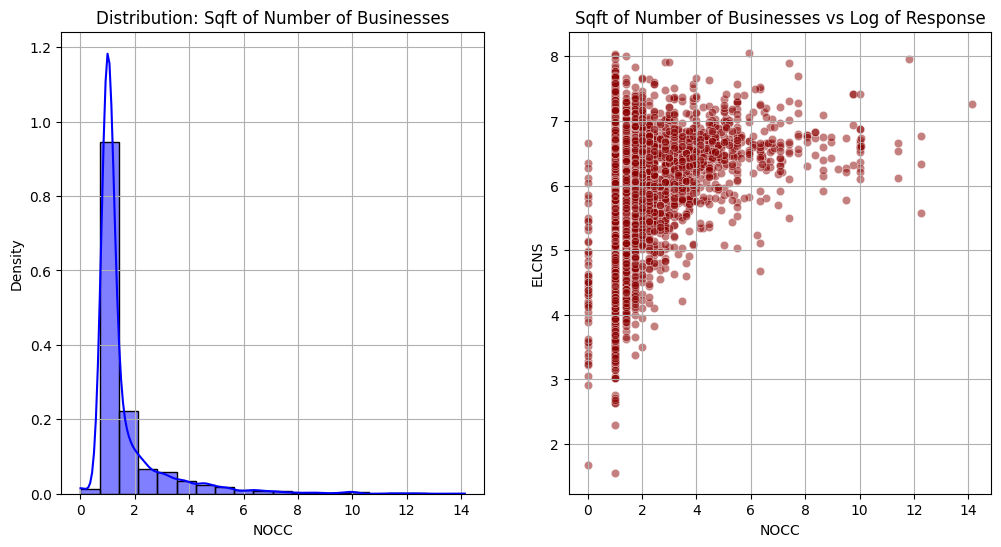

In [40]:
# First plot: Histogram with KDE (smooth density plot)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(np.sqrt(cbecs3['NOCC']), kde=True, color='blue', edgecolor='black', \
                 stat = 'density', bins = 20)
plt.title('Distribution: Sqft of Number of Businesses')
plt.grid()

    
# Second plot: Scatter plot with response
plt.subplot(1, 2, 2)
sns.scatterplot(x=np.sqrt(cbecs3['NOCC']), y=np.log10(cbecs3['ELCNS']), color='darkred', alpha = 0.5)
plt.title('Sqft of Number of Businesses vs Log of Response')
plt.grid()

#plt.tight_layout()
plt.show()

**WKHRS** - work hours of the establishment

- Bi-modal: there is one mode around 40 and another around 160
- The outlier in this case is the 2nd mode
- Transforming this variable to reduce the outlier might remove the useful information that we need to capture
- It seems like standard scaling should suffice in this case, so no transformation is needed

**SQFT** - square footage of the building
- Severely right-skewed, the range of values is between 0 and 2M
- Transformation is needed to address strong outliers
- Log transformation seems appropriate (just like in the response case)

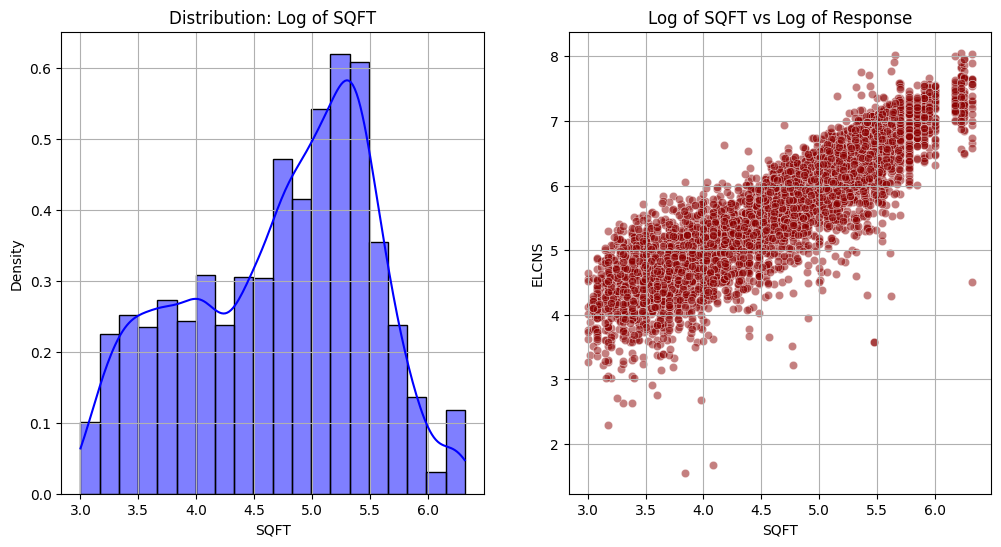

In [41]:
# First plot: Histogram with KDE (smooth density plot)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # Dina reminder: 1 row, 2 columns, 1st plot
sns.histplot(np.log10(cbecs3['SQFT']), kde=True, color='blue', edgecolor='black', \
                 stat = 'density', bins = 20)
plt.title('Distribution: Log of SQFT')
plt.grid()

    
# Second plot: Scatter plot with response
plt.subplot(1, 2, 2)
sns.scatterplot(x=np.log10(cbecs3['SQFT']), y=np.log10(cbecs3['ELCNS']), color='darkred', alpha = 0.5)
plt.title('Log of SQFT vs Log of Response')
plt.grid()

#plt.tight_layout()
plt.show()

Log transformation took care of outliers and also improved the linear relationship between Log of Response

**OCCUPYP** - percent occupancy
- It's either 0 or 100 percent
- Seems like this would be better as a categorical variable with categories: 0 percent, 100 percent and <100

In [42]:
# Percent of observations for occupancy
print("Equal to 0: ", sum(cbecs3['OCCUPYP']==0)/cbecs3.shape[0])
print("Greater than 0 and Less than 100: ", sum((cbecs3['OCCUPYP']>0) & (cbecs3['OCCUPYP']<100))/cbecs3.shape[0])
print("Equal to 100: ", sum(cbecs3['OCCUPYP']==100)/cbecs3.shape[0])

Equal to 0:  0.7185779455718107
Greater than 0 and Less than 100:  0.15290231241151486
Equal to 100:  0.12851974201667454


**FLCEILHT** - floor to ceiling height
- Right skewed
- No severe outliers, the range of the data is not extreme
- Standard Scaler should be enough
- Appears to have zero correlation (linear or otherwise) with the Log of Response

**MONUSE** - months in use
- It's either 12 or not 12
- Could be changed into a categorical variable

In [43]:
# Percent of observations for months in use
print("Equal to 12: ", sum(cbecs3['MONUSE']==12)/cbecs3.shape[0])
print("Not Equal to 12: ", sum(cbecs3['MONUSE']!=12)/cbecs3.shape[0])

Equal to 12:  0.8780871480257983
Not Equal to 12:  0.12191285197420167


**CDD65** - cooling degree days
- Bi-modal
- Only slightly right-skewed
- Range: 0 to slightly greater than 5K
- This can be considered count data, to compress the range a little, can try sqrt transformation

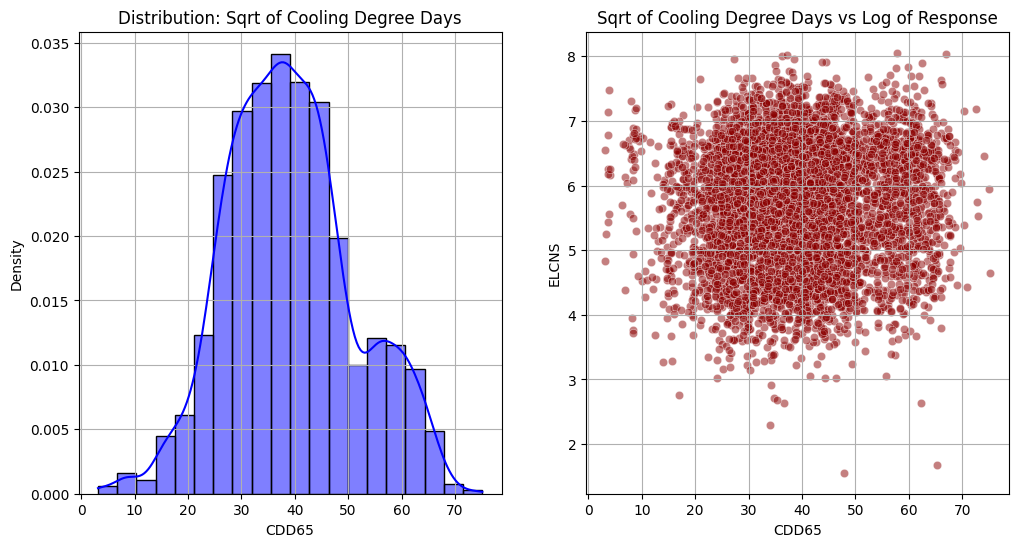

In [44]:
# First plot: Histogram with KDE (smooth density plot)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # Dina reminder: 1 row, 2 columns, 1st plot
sns.histplot(np.sqrt(cbecs3['CDD65']), kde=True, color='blue', edgecolor='black', \
                 stat = 'density', bins = 20)
plt.title('Distribution: Sqrt of Cooling Degree Days')
plt.grid()

    
# Second plot: Scatter plot with response
plt.subplot(1, 2, 2)
sns.scatterplot(x=np.sqrt(cbecs3['CDD65']), y=np.log10(cbecs3['ELCNS']), color='darkred', alpha = 0.5)
plt.title('Sqrt of Cooling Degree Days vs Log of Response')
plt.grid()

#plt.tight_layout()
plt.show()

- Distribution is more symmentric now
- Relationship with response is complicated

**FRIDGE** - number of refrigeration units of various types
- Strongly right skewed
- Outliers present, but they only range from 300 to 1,400
- Because the orders of magnitude are not extreme, let's try Box-Cox transform - it's versatile

Note: Box-Cox tranformation is a type of Power transformation that makes the data more normal (stabilizes variance)

In [45]:
# Box-Cox transform for FRIDGE

box_cox_fridge, best_lambda1 = boxcox(cbecs3['FRIDGE'])

print("Best lambda: ", best_lambda1)

Best lambda:  -0.8504036962893338


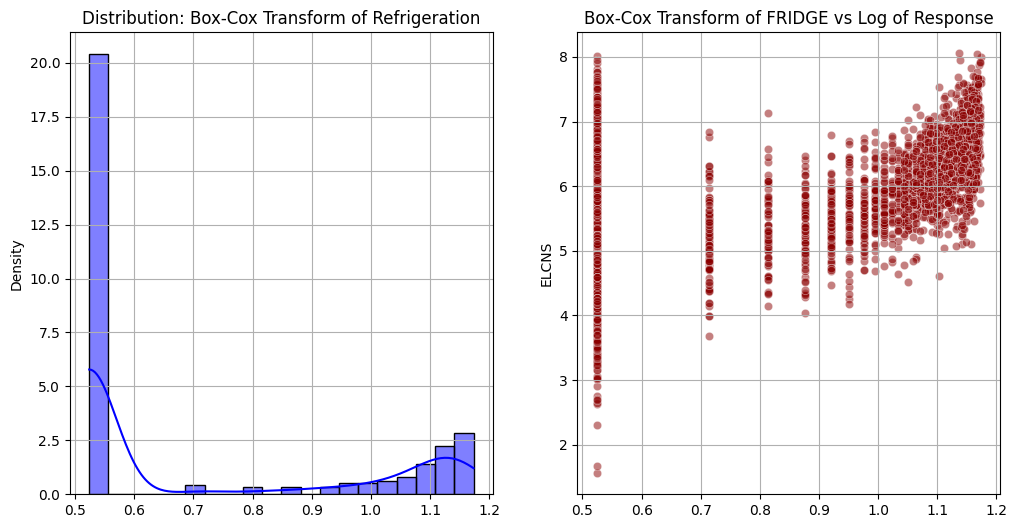

In [46]:
# First plot: Histogram with KDE (smooth density plot)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # Dina reminder: 1 row, 2 columns, 1st plot
sns.histplot(box_cox_fridge, kde=True, color='blue', edgecolor='black', \
                 stat = 'density', bins = 20)
plt.title('Distribution: Box-Cox Transform of Refrigeration')
plt.grid()

    
# Second plot: Scatter plot with response
plt.subplot(1, 2, 2)
sns.scatterplot(x=box_cox_fridge, y=np.log10(cbecs3['ELCNS']), color='darkred', alpha = 0.5)
plt.title('Box-Cox Transform of FRIDGE vs Log of Response')
plt.grid()

#plt.tight_layout()
plt.show()

The range has been compressed with this transformation

**CAPACITY** - manually created variable to capture seating or lodging capacity
- Similar distribution to FRIDGE
- Let's try the Box-Cox transform

In [47]:
# Box-Cox transform for CAPACITY
box_cox_capacity, best_lambda2 = boxcox(cbecs3['CAPACITY'])
print("Best lambda: ", best_lambda2)

Best lambda:  0.06865659979508115


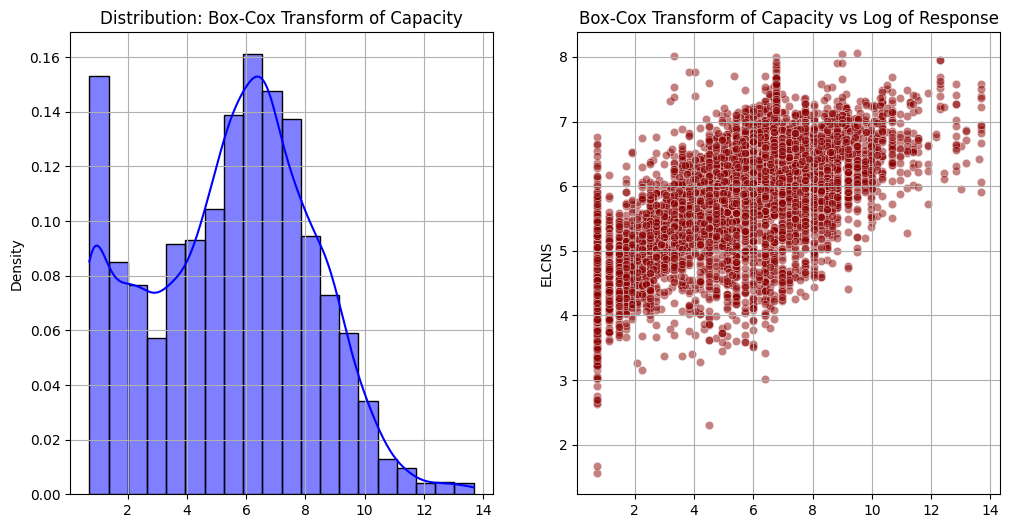

In [48]:
# First plot: Histogram with KDE (smooth density plot)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # Dina reminder: 1 row, 2 columns, 1st plot
sns.histplot(box_cox_capacity, kde=True, color='blue', edgecolor='black', \
                 stat = 'density', bins = 20)
plt.title('Distribution: Box-Cox Transform of Capacity')
plt.grid()

    
# Second plot: Scatter plot with response
plt.subplot(1, 2, 2)
sns.scatterplot(x=box_cox_capacity, y=np.log10(cbecs3['ELCNS']), color='darkred', alpha = 0.5)
plt.title('Box-Cox Transform of Capacity vs Log of Response')
plt.grid()

#plt.tight_layout()
plt.show()

**EQUIP** - derived variable to capture the counts of computer and other office equipment. 
<br>
- Right skewed
- Some outliers: most of the data is concentrated between 0 and 2K, outliers are >2K to 6K
- Because we have count data and there are moderate outliers, we can consider either a square root transformation or a Box-Cox transformation
- Relationship with response: not linear, resembles either log or square root

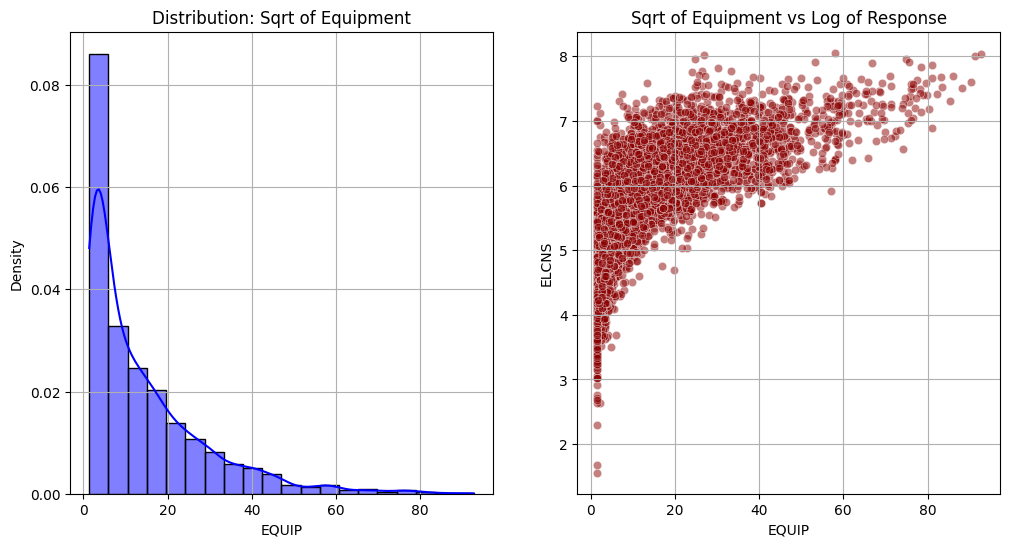

In [49]:
# First plot: Histogram with KDE (smooth density plot)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # Dina reminder: 1 row, 2 columns, 1st plot
sns.histplot(np.sqrt(cbecs3['EQUIP']), kde=True, color='blue', edgecolor='black', \
                 stat = 'density', bins = 20)
plt.title('Distribution: Sqrt of Equipment')
plt.grid()

    
# Second plot: Scatter plot with response
plt.subplot(1, 2, 2)
sns.scatterplot(x=np.sqrt(cbecs3['EQUIP']), y=np.log10(cbecs3['ELCNS']), color='darkred', alpha = 0.5)
plt.title('Sqrt of Equipment vs Log of Response')
plt.grid()

#plt.tight_layout()
plt.show()

In [50]:
# Let's try the Box-Cox transformation on the equipment variable

# Perform transformation, add a small positive value so that all data is >0
box_cox_equip, best_lambda = boxcox(cbecs3['EQUIP'])

print("Best lambda: ", best_lambda)

Best lambda:  0.017476382481441


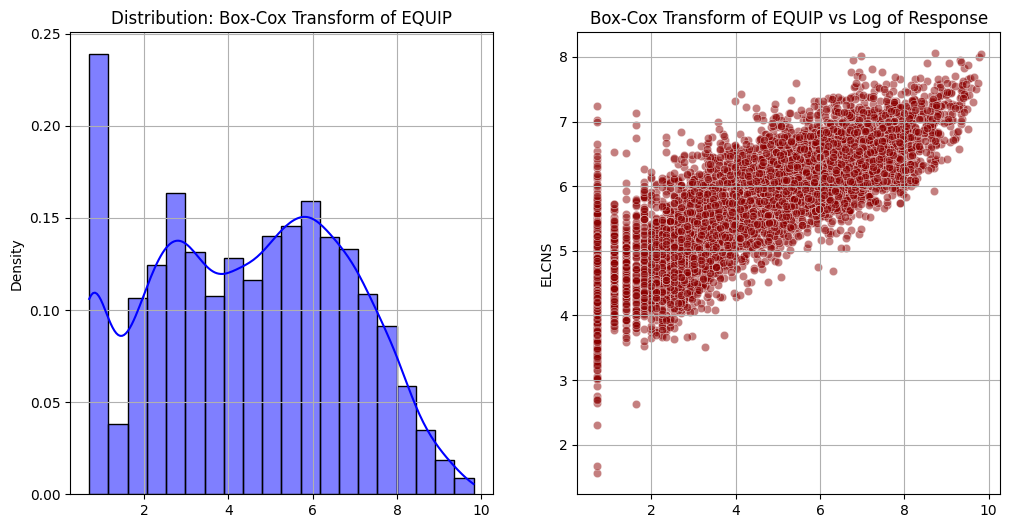

In [51]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # Dina reminder: 1 row, 2 columns, 1st plot
sns.histplot(box_cox_equip, kde=True, color='blue', edgecolor='black', \
                 stat = 'density', bins = 20)
plt.title('Distribution: Box-Cox Transform of EQUIP')
plt.grid()

    
# Second plot: Scatter plot with response and a smooth fit line
plt.subplot(1, 2, 2)
sns.scatterplot(x=box_cox_equip, y=np.log10(cbecs3['ELCNS']), color='darkred', alpha = 0.5)
plt.title('Box-Cox Transform of EQUIP vs Log of Response')
plt.grid()

#plt.tight_layout()
plt.show()

This looks significantly less skewed and a more pronounced linear relationship with Log of Response

**NELEVESC** - number of elevators and escalators
- 0 most popular value
- Right-skewed with the max being 40
- Because the outliers cap at 40, we may or may not need any transformations
- We can try square root to stabilize the variance

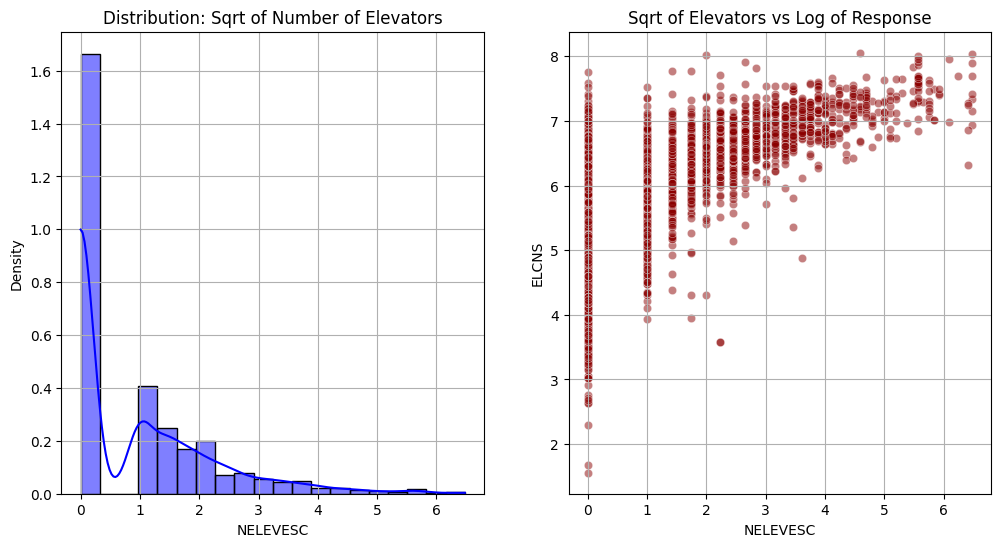

In [52]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # Dina reminder: 1 row, 2 columns, 1st plot
sns.histplot(np.sqrt(cbecs3['NELEVESC']), kde=True, color='blue', edgecolor='black', \
                 stat = 'density', bins = 20)
plt.title('Distribution: Sqrt of Number of Elevators')
plt.grid()

    
# Second plot: Scatter plot with response and a smooth fit line
plt.subplot(1, 2, 2)
sns.scatterplot(x=np.sqrt(cbecs3['NELEVESC']), y=np.log10(cbecs3['ELCNS']), color='darkred', alpha = 0.5)
plt.title('Sqrt of Elevators vs Log of Response')
plt.grid()

#plt.tight_layout()
plt.show()

**Summary of numeric transformations**
- **WKHRS**: no transformation
- **SQFT**: log10
- **OCCUPYP**: make categorical -> '0', '1 to 99', '100'
- **FLCEILHT**: no transformation
- **MONUSE**: make categorical -> '12', '<12'
- **CDD65**: sqrt
- **NFLOOR**: no transformation
- **FRIDGE**: box_cox_fridge
- **CAPACITY**: box_cox_capacity
- **OFFICE**: box_cox_office
- **NELEVESC**: sqrt
- **NOCC**: sqrt

In [53]:
# Perform transformations - create a copy of the df first
cbecs4 = cbecs3.copy()

cbecs4['SQFT'] = np.log10(cbecs3['SQFT'])
cbecs4['OCCUPYP'] = np.where(cbecs3['OCCUPYP']==0, '0', np.where(cbecs3['OCCUPYP']=='100', '100', '1-99'))
cbecs4['MONUSE'] = np.where(cbecs3['MONUSE']==12, '12', '<12')
cbecs4['CDD65'] = np.sqrt(cbecs3['CDD65'])
cbecs4['FRIDGE'] = box_cox_fridge
cbecs4['EQUIP'] = box_cox_equip
cbecs4['CAPACITY'] = box_cox_capacity
cbecs4['NELEVESC'] = np.sqrt(cbecs3['NELEVESC'])
cbecs4['ELCNS'] = np.log10(cbecs3['ELCNS'])

In [54]:
# Update variable list
for var in ['OCCUPYP', 'MONUSE']:
    numeric3.remove(var)
    categorical.append(var)

In [55]:
# Categorical variables with lots of categories
frequency_encoding = ['PBA', 'WLCNS', 'RFCNS', 'BLDSHP', 'GLSSPC', 'YRCONC', 'MAINHT', 'MAINCL', 'CENDIV', 'WINTYP']

### Encode categorical variables, split into train/test, scale numeric

Variables in the list **frequency_encoding** have many categories. Using  one-hot-encoding on these would lead to high-dimensionality and a sparse matrix. To avoid this, we will use frequency embedding. Other categorical variables with only a few categories will get the one-hot-encoding.

In [56]:
# Function to handle one-hot-encoding

def create_dummies(df, num_variables, one_hot_variables, other_categorical):
    '''Note the list of numeric variables num_variables should not include response'''
    
    # Subset numerics only
    X_numeric = df[num_variables]
    
    # Subset other categorical
    X_categorical = df[other_categorical]

    # Create blank df for dummies
    X_dummy = pd.DataFrame()

    # Create dummy variables for categorical
    for var in one_hot_variables:
        current_dummy = pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first = True).astype(int)
        X_dummy = pd.concat([X_dummy, current_dummy], axis = 1)
    
    # Concat X with the dummy columns
    X = pd.concat([X_numeric, X_dummy, X_categorical], axis = 1)

    # Complete list of all categorical variable names
    new_cat_variables = list(set(list(X.columns)) - set(num_variables))
    
    return new_cat_variables, X

In [177]:
# Function for train-test splitting and scaling

def train_test_scale(X, y, num_variables, cat_variables):
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    
    # Split between training and calibration (for Conformal Prediction)
    X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size = 0.13)
    
    # Standard Scaler for the predictors
    scaler = StandardScaler()
    
    # Fit scaler on the numeric part of the train data and apply the same parameters to scaling the test portion
    X_train_numeric_scaled = scaler.fit_transform(X_train[num_variables])
    X_cal_numeric_scaled = scaler.transform(X_cal[num_variables])
    X_test_numeric_scaled = scaler.transform(X_test[num_variables])

    # Convert the scaled numeric data back to a DataFrame
    X_train_numeric_scaled = pd.DataFrame(X_train_numeric_scaled, columns=num_variables, index=X_train.index)
    X_cal_numeric_scaled = pd.DataFrame(X_cal_numeric_scaled, columns=num_variables, \
                                        index=X_cal.index)
    X_test_numeric_scaled = pd.DataFrame(X_test_numeric_scaled, columns=num_variables, index=X_test.index)

    # Concatenate the scaled numeric columns with the categorical columns
    X_train_scaled = pd.concat([X_train_numeric_scaled, X_train[cat_variables]], axis=1)
    X_calibration_scaled = pd.concat([X_cal_numeric_scaled, X_cal[cat_variables]], axis=1)
    X_test_scaled = pd.concat([X_test_numeric_scaled, X_test[cat_variables]], axis=1)
    
    # Scaler for the response
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(np.array(y_train).reshape(-1, 1)).flatten()
    y_calibration_scaled = scaler_y.fit_transform(np.array(y_calibration).reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(np.array(y_test).reshape(-1, 1)).flatten()
    mean_response = scaler_y.mean_ 
    std_dev_response = scaler_y.scale_
    
    return X_train_scaled, X_test_scaled, X_calibration_scaled, y_calibration_scaled, \
y_train_scaled, y_test_scaled, mean_response, std_dev_response

In [174]:
# Function for the embedding

# This function will be run separately on the train and test portions of the data
def embed_categories(df, variable_list):
    
    # Maintain a single column for categoricals with many categories
    # Replace categories with frequencies
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Change datatypes to 'float' to accomodate frequencies
        for var in variable_list:
            categories = list(df[var].unique())
            df.loc[:, var] = df.loc[:, var].astype('float64')
        
            # Obtain frequency and paste it
            for cat in categories:
                freq = sum(df[var] == cat)/df.shape[0]
            
                df.loc[df[var] == cat, var] = freq
            
    return df  

In [175]:
# List of variables with few categories
one_hot_vars = list(set(categorical) - set(frequency_encoding))

# Create dummy variables
categorical2, X = create_dummies(cbecs4, numeric3, one_hot_vars, frequency_encoding)

In [181]:
# Run train_test_scale

X_train_scaled, X_test_scaled, X_calibration_scaled, y_calibration_scaled, y_train_scaled, y_test_scaled,\
mean_y, std_y = train_test_scale(X, cbecs4['ELCNS'], numeric3, categorical2)

In [182]:
# Run the function to embed categories
X_train_scaled = embed_categories(X_train_scaled, frequency_encoding)
X_calibration_scaled = embed_categories(X_calibration_scaled, frequency_encoding)
X_test_scaled = embed_categories(X_test_scaled, frequency_encoding)

In [166]:
print("Final Number of Variables: ", len(X_train_scaled.columns))

Final Number of Variables:  47


In [167]:
# Check results for the PBA variable - frequencies embedded
print(X_train_scaled['PBA'].unique())
print("")
print(X_test_scaled['PBA'].unique())

[0.0310428  0.01506932 0.05213984 0.20976492 0.0331525  0.14556962
 0.08016878 0.10699216 0.06449668 0.05786618 0.04008439 0.03405666
 0.01748041 0.04279687 0.01567209 0.00512357 0.01145268 0.0177818
 0.00361664]

[0.15336217 0.20526937 0.05465985 0.04797483 0.11993708 0.0703893
 0.05151396 0.04168305 0.06763665 0.01454974 0.03381832 0.01101062
 0.01022414 0.00825796 0.03303185 0.01848211 0.00589855 0.00393236]


In [65]:
cbecs4.MAINHT.value_counts()/cbecs4.shape[0]

MAINHT
11.0     0.214724
10.0     0.193173
2.0      0.145981
9.0      0.068114
27.0     0.063867
99.0     0.055057
4.0      0.050024
999.0    0.043574
7.0      0.037596
5.0      0.026899
13.0     0.022810
1.0      0.019821
17.0     0.016832
28.0     0.015888
3.0      0.013056
42.0     0.012585
Name: count, dtype: float64

# Build Models

## Linear Regression - Base Model

Ridge Regression was selected as the base model due to its ability to handle multicollinearity.

In [183]:
#Initialize the Ridge model.
# Note: auto solver selects the best solver for the type of data we have
linear_model = Ridge(alpha=20, fit_intercept=True, max_iter=1000, tol=1e-4, solver='auto')

# Fit the model on the training set
linear_model.fit(X_train_scaled, y_train_scaled)

# Make predictions on the test set
y_pred_train_lm = linear_model.predict(X_train_scaled)
y_pred_test_lm = linear_model.predict(X_test_scaled)

print("R^2 training: ", r2_score(y_train_scaled, y_pred_train_lm))
print("R^2 test: ", r2_score(y_test_scaled, y_pred_test_lm))
print("")

# Look at top 7 coefficients
coef_df = pd.DataFrame(linear_model.coef_, X_train_scaled.columns, columns = ['coef']).reset_index()
coef_df['abs_coef'] = abs(coef_df['coef'])

print("Top 7 variables: ")
coef_df = coef_df.sort_values(by = 'abs_coef', ascending = False)
print(coef_df.iloc[0:7, 0:2].to_string(index=False))

R^2 training:  0.8898600708376465
R^2 test:  0.885307961926512

Top 7 variables: 
     index      coef
      SQFT  0.555808
       PBA -0.360934
     EQUIP  0.160908
     WKHRS  0.160601
  RFTILT_3 -0.138029
MONUSE_<12 -0.122725
    GLSSPC -0.120969


Top seven variables include:
- Square footage (SQFT)
- Type of building (PBA)
- Equipment count (EQUIP): count of all electrical equipment, such as computers, servers, printers, etc.
- Hours open during the week (WKHRS)
- Roof tilt (RFTILT): tilted roof is able to absord less sunlight
- Building is used less than 12 months per year (MONUSE_<12)
- Percent exterior glass (GLSSPC)

### Build Neural Network1 for Point Predictions

In [270]:
def build_model1(hp):
    
    model = tf.keras.Sequential()
        
    # Specify input layer badesd on the number of features
    model.add(tf.keras.layers.Input(shape = (X_train_scaled.shape[1],)))
        
    # Hyperparameter: specify the range of neurons to search over 
    hp_units1 = hp.Int('units1', min_value=5, max_value=45, step=2)
    
    # Hyperparameter: specify the range of neurons to search over 
    hp_units2 = hp.Int('units2', min_value=5, max_value=45, step=2)
        
    # First Hidden layer
    model.add(tf.keras.layers.Dense(units = hp_units1, activation = 'swish',\
              kernel_regularizer=regularizers.l2(0.001)))
        
    # Second Hidden layer
    model.add(tf.keras.layers.Dense(units = hp_units2, activation = 'swish', \
             kernel_regularizer=regularizers.l2(0.001)))
    
    # Output layer
    model.add(tf.keras.layers.Dense(1))
    
    # Hyperparameters: Optimizer and Learning rate
    hp_optimizer_name = hp.Choice('optimizer', values=['adam', 'sgd'])
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.0001])
    
    # Add optimizer and learning rate chosen
    if hp_optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
    
    model.compile(optimizer=optimizer, loss='mse')

    return model

Here is the total parameter space:
    
$20 * 20 * 2 * 3 = 2,400$

- 20 neuron possibilities in each layer
- 2 optimiers and 3 learning rates

In [265]:
# Set up the tuner
tuner1 = BayesianOptimization(
    build_model1,             
    objective = 'val_loss',  
    max_trials = 30,   #  (max_trials - initial) hp combinations to evaluate once Bayesian optimization kicks in    
    num_initial_points=5, # number of hp combinations that are first randomly selected
    seed = 42,
    directory = 'bayesian_tuner',
    project_name = 'point_predictions'
)

# Perform search with the tuner: each of the [max_trials] hp combinations will be run for specified epochs
tuner1.search(X_train_scaled, y_train_scaled, epochs = 100, validation_split = 0.25, verbose = 1)

# Get the best hyperparameters
best_hps1 = tuner1.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 20s]
val_loss: 0.12193439900875092

Best val_loss So Far: 0.11765523999929428
Total elapsed time: 00h 10m 42s


In [267]:
# Print the values of the best hyperparameters
print(f"Best number of units in the first hidden layer: {best_hps1.get('units1')}")
print(f"Best number of units in the second hidden layer: {best_hps1.get('units2')}")
print(f"Best optimizer: {best_hps1.get('optimizer')}")
print(f"Best learning rate: {best_hps1.get('learning_rate')}")

Best number of units in the first hidden layer: 5
Best number of units in the second hidden layer: 17
Best optimizer: adam
Best learning rate: 0.001


In [271]:
# Build the model with the best hyperparameters and train it
model1 = tuner1.hypermodel.build(best_hps1)

# Fit the model
history1 = model1.fit(X_train_scaled, y_train_scaled, epochs = 100, batch_size=32,\
                    validation_split = 0.25, verbose = 0)

# Use the model to predict
y_pred_train = model1.predict(X_train_scaled)
y_pred_test = model1.predict(X_test_scaled)

print("R^2 training:", r2_score(y_train_scaled, y_pred_train))
print("R^2 test:", r2_score(y_test_scaled, y_pred_test))

80/80 [==============================] - 0s 848us/step
R^2 training: 0.8974675259624899
R^2 test: 0.8877506449682606


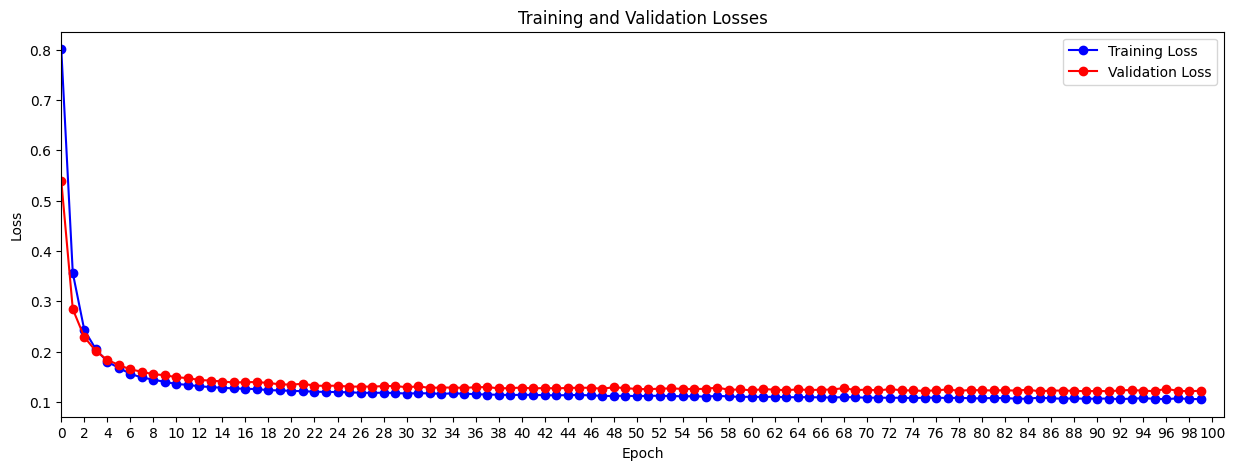

In [272]:
# Get training and validation loss
training_loss = history1.history['loss']
validation_loss = history1.history['val_loss']

# Visualize losses
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(training_loss, marker = 'o', color='blue', label = 'Training Loss')
plt.plot(validation_loss, marker = 'o', color = 'red', label = 'Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim([0, len(validation_loss) + 1])
plt.xticks(np.arange(0, len(validation_loss) + 1, step=2))
plt.legend()
plt.show()